In [2]:
# imports
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import cv2

# Step 1: Loading the Images
The image sequence is all loaded into a directory named in order of their capture.

In [3]:
# Load the images in the photos/ directory
def load_images(dir='photos/'):
    # Get the list of files in the photos/ directory
    files = os.listdir(dir)
    
    files = sorted(files)
    print(files)
    
    # Load the images
    images = []
    for file in files:
        if not file.startswith('.'):
            image = cv2.imread(dir + file)
            images.append(image)
    return images

In [4]:
# load the photos
photos = load_images()

['.DS_Store', 'top0800.JPG', 'top0845.JPG', 'top0915.JPG', 'top0930.JPG', 'top1130.JPG', 'top1220.JPG', 'top1425.JPG', 'top1630.JPG', 'top1730.jpeg']


In [11]:
#display the first image to check if it is loaded correctly
cv2.imshow('image', photos[0])
cv2.waitKey(0)
cv2.destroyAllWindows()


In [6]:
# check pixel count
photos[1].shape

(4032, 3024, 3)

# Step 2: Image Registration

## SIFT Detection

In [7]:
# Apply the SIFT detector to the images
def sift(images):
    # Create the SIFT detector
    sift = cv2.SIFT_create()
    # Apply the SIFT detector to the images
    keypoints = []
    descriptors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        keypoints.append(kp)
        descriptors.append(des)
    return keypoints, descriptors

In [8]:
# Converting image to grayscale
gray = [cv2.cvtColor(photo,cv2.COLOR_BGR2GRAY) for photo in photos]

kp, des = sift(gray)

Optionally, this code was used in order to inspect the results of the SIFT detector.

In [7]:
# Marking the keypoint on the image using circles
def mark(images, kps):
    photos_kp = []]
    for i in range(len(images)):
        image = images[i]
        kp = kps[i]
        photos_kp.append(cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    return photos_kp


In [8]:
photos_kp = mark(photos, kp)

In [35]:
# display the images with keypoints
photos_resize = []

# resize the images
for i in range(len(photos_kp)):
    # display the image at 20% of the original size
    photos_resize.append(cv2.resize(photos_kp[i], (0,0), fx=0.2, fy=0.2))

# display the images
for i in range(len(photos_resize)):
    cv2.imshow(f'image{i}', photos_resize[i])
    cv2.waitKey(0)    

cv2.waitKey(0)

100

## Brute Force Matching
Painfully slow but effective for matching!

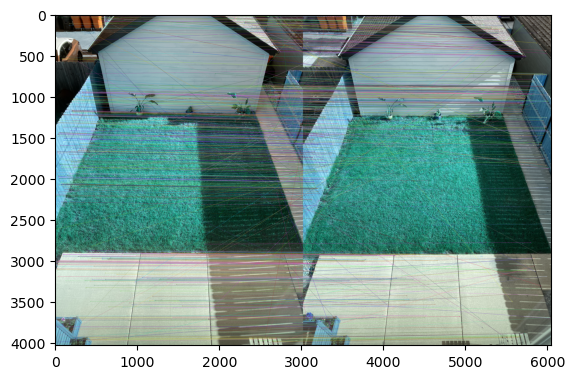

In [11]:
## Testing with first 2 images

# match image 1 and 2
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(des[0],des[1],k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(photos[0],kp[0],photos[1],kp[1],good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# display the image
plt.imshow(img3)

In [9]:
# Function to match the keypoints for all of the images
def match_keypoints(descriptors, ref):
    '''This function matches the keypoints of all the images with the reference image provided as an index in the list of descriptors.'''    

    matcher = cv2.BFMatcher()
    
    out_match = []
    out_good = []
    
    for i in range(len(descriptors)):
        if i == ref:
            out_match.append(None)
            out_good.append(None)
            continue
        matches = matcher.knnMatch(descriptors[i], descriptors[ref], k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good.append([m])
        out_match.append(matches)
        out_good.append(good)
        
    return out_match, out_good

In [10]:
# Match the keypoints for all the images, image #4 was used as the reference image because it is midday and more zoomed out.
matches, good = match_keypoints(des, 3)

## Using RANSAC to find the transformation matrix and then perform the transformation

In [11]:
# Function to apply the homography to all the images
def apply_homography(images, kp, good, ref):
    '''This function applies the homography to all the images using the keypoints and good matches.
    args:
    images: list of images
    kp: list of keypoints
    good: list of good matches
    ref: reference image index
    '''
    
    homographies = []
    
    for i in range(len(images)):
        if i == ref:
            homographies.append(images[i])
            continue
        # print(i)
        src_pts = np.float32([kp[i][m[0].queryIdx].pt for m in good[i]]).reshape(-1,1,2)
        dst_pts = np.float32([kp[ref][m[0].trainIdx].pt for m in good[i]]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        h,w = images[i].shape[:2]
        im_out = cv2.warpPerspective(images[i], M, (w,h))
        homographies.append(im_out)
        
    return homographies

In [12]:
# Apply the homography to all the images
homographies = apply_homography(photos, kp, good, 3)

In [21]:
# Create a time lapse video for fun
def create_video(images, output='output.avi'):
    '''This function creates a video from the images provided.'''
    
    # Get the height and width of the images
    h, w = images[0].shape[:2]
    
    # Create a video writer object
    out = cv2.VideoWriter(output, cv2.VideoWriter_fourcc(*'MJPG'), 1, (w, h))
    
    # Write the images to the video
    for image in images:
        out.write(image)
    
    # Release the video writer object
    out.release()


In [30]:
create_video(homographies, 'output_homographies.avi')

[ WARN:0@1010.933] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
[ERROR:0@1010.933] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap.cpp (597) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): output_homographies.avi in function 'icvExtractPattern'




# Step 3: Focusing on the region of interest
The lawn is where I want to sun map as this is where the garden beds could feasibly be planted and unfortunately, our lighting maps will be thrown off by the different reflective properties of the concrete patio and brightly painted siding for the garage.

In [15]:
# Function to select rectangular region of interest from an image
def select_ROI(image):
    # Display the image
    cv2.imshow('Select ROI', image)
    # Select ROI
    roi = cv2.selectROI('Select ROI', image)
    # Close the window
    cv2.destroyAllWindows()
    # Return the ROI
    return roi

def crop_ROI(images, template):
    # Crop the template from the image
    cropped_images = []
    for image in images:
        template_cropped = image[int(template[1]):int(template[1] + template[3]), int(template[0]):int(template[0] + template[2])]
        cropped_images.append(template_cropped)
    return cropped_images
    

In [16]:
box = select_ROI(photos[3])

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


In [64]:
boxed_homographies = crop_ROI(homographies, box)

plt.imshow(boxed_homographies[0])

In [38]:
# create a mask with white pixels
mask = np.ones(photos[3].shape, dtype=np.uint8)
mask.fill(255)

# Assign the ROI corners
roi_corners = np.array([[(580, 1630), (2350, 1650), (3010, 3320), (10, 3360)]], dtype=np.int32)

# fill the ROI into the mask
cv2.fillPoly(mask, roi_corners, 0)

# applying th mask to original image
masked_image = cv2.bitwise_or(homographies2[0], mask)

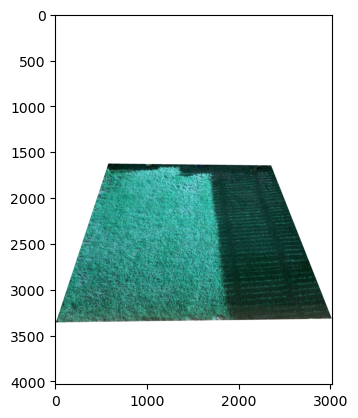

In [78]:
# check that the ROI corners are correct
plt.imshow(masked_image)

In [40]:
# Function to project the ROI onto a rectangle for all the images
def project_ROI(images, roi, size=(1600,1600)):
    '''This function projects the ROI onto a rectangle for all the images.'''
    
    # Define the source and destination points
    src_pts = np.array(roi, dtype=np.float32)
    dst_pts = np.array([[(0, 0), (size[0], 0), (size[0], size[1]), (0, size[1])]], dtype=np.float32)
    
    img_out = []
    
    for image in images:
        M, _ = cv2.findHomography(src_pts, dst_pts)
        im_out = cv2.warpPerspective(image, M, size)
        img_out.append(im_out)
        
    return img_out

In [70]:
boxed_homographies = project_ROI(homographies, roi_corners)

In [42]:
create_video(boxed_homographies, 'output_perspective.avi')

[ WARN:0@3071.438] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
[ERROR:0@3071.438] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap.cpp (597) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): output_perspective.avi in function 'icvExtractPattern'




# Step 4: Generating illumination maps

## Histogram Equalization

In [23]:
# First step is to perform histogram equalization on the images
def histogram_equalization(images):
    '''This function converts images to grayscale and then performs histogram equalization.'''
    
    # Convert the images to grayscale
    gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]
    
    # Perform histogram equalization
    equalized = [cv2.equalizeHist(image) for image in gray]
    
    return equalized
    

In [43]:
photos_eq = histogram_equalization(boxed_homographies)

## Plane fitting with quadratic model

In [25]:
from scipy.optimize import curve_fit

# define a function to return quadratic brightness map from images
def brightness_map(images):
    '''This function returns the brightness map of the images.'''
    
    # Helper function to define the quadratic function
    def quadratic_function(coords, a, b, c, d, e, f):
        x, y = coords
        return a * x**2 + b * y**2 + c * x * y + d * x + e * y + f
    
    # Get the dimensions of the image
    height, width = images[0].shape[:2]
    
    # Generate x and y coordinates
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    
    # Flatten the arrays
    x_flat = x.flatten()
    y_flat = y.flatten()
    
    brightness_maps = []
    
    for image in images:
        # Flatten the image
        z_flat = image.flatten()
        
        # Fit the quadratic function to the data
        initial_guess = (1, 1, 1, 1, 1, 1)
        params, _ = curve_fit(quadratic_function, (x_flat, y_flat), z_flat, p0=initial_guess)
        
        # Create the brightness map using the fitted quadratic function
        brightness_map = quadratic_function((x, y), *params)
        
        brightness_maps.append(brightness_map)
        
    return brightness_maps

def plot_image_map(image, brightness_map):
    # Plot the original image and the brightness map
    height, width = image.shape[:2]
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(brightness_map, cmap='gray')
    ax[1].set_title('Brightness Map')
    ax[1].axis('off')

    # Plot the brightness map in 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, brightness_map, cmap='viridis')
    ax.set_title('Brightness Map')

    plt.show()

In [44]:
photos_crop_brightness = brightness_map(photos_eq)

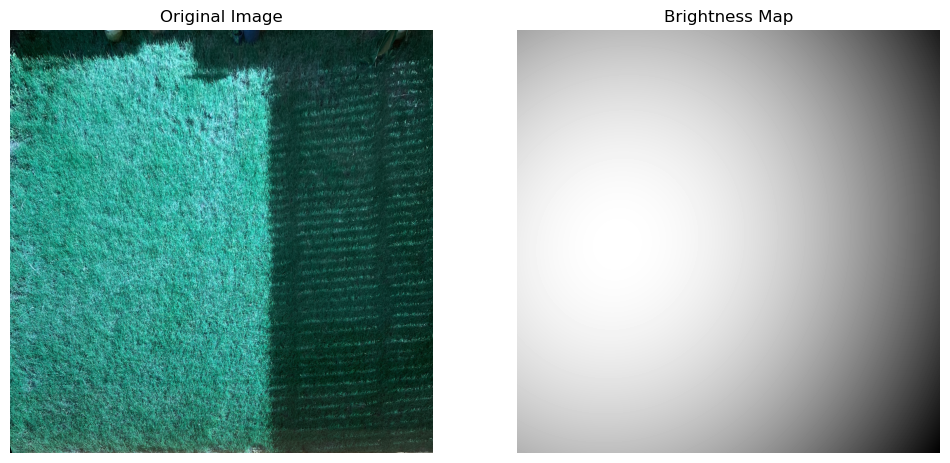

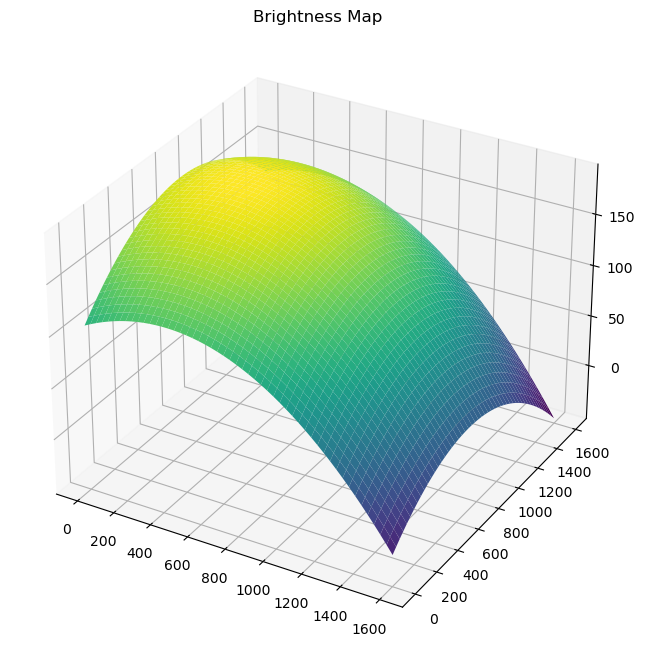

In [46]:
plot_image_map(boxed_homographies[0], photos_crop_brightness[0])

# Step 5: Projecting brightness maps back onto the reference image

## Average all the brightness maps

In [47]:
# Blend the brightness maps into one single brightness map
def blend_brightness_maps(brightness_maps):
    '''This function blends the brightness maps into a single brightness map.'''
    
    # Convert the brightness maps to numpy arrays
    brightness_maps = np.array(brightness_maps)
    
    # Calculate the mean of the brightness maps
    mean_brightness_map = np.mean(brightness_maps, axis=0)
    
    return mean_brightness_map

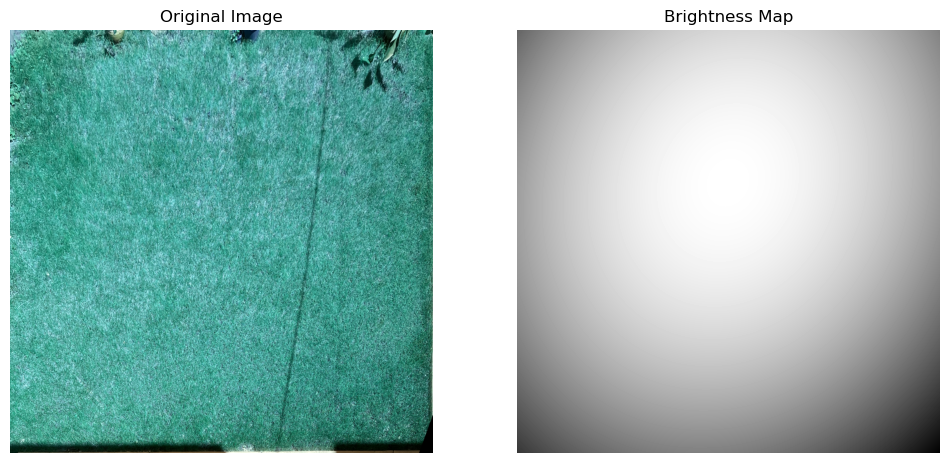

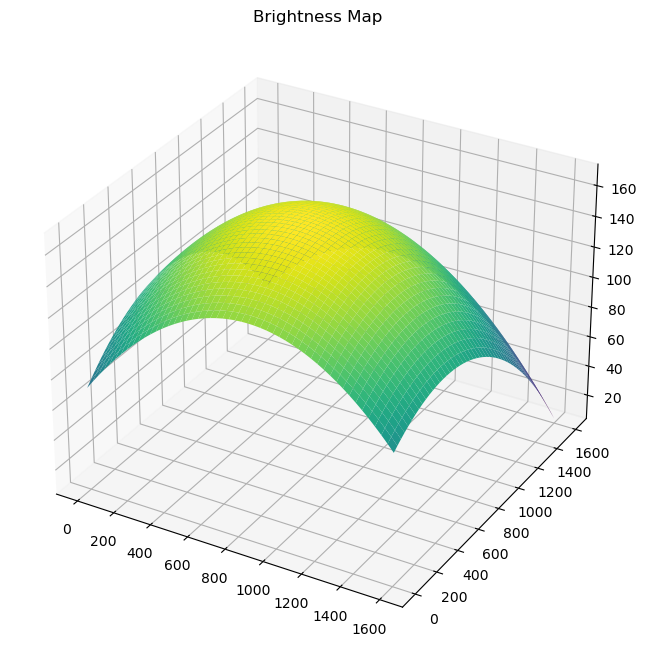

In [48]:
photos_brightness = blend_brightness_maps(photos_crop_brightness)

# Plot the blended brightness map
plot_image_map(boxed_homographies[3], photos_brightness)

## Project brightness map as a "heat map" back onto the original reference image

In [51]:
# Overlay the heatmap of the brightness map projected onto the original reference image
def project_heatmap(image, brightness_map, roi):
    '''This function projects the heatmap of the brightness map onto the original reference image.'''
    
    # Normalize the brightness map
    brightness_map = (brightness_map - np.min(brightness_map)) / (np.max(brightness_map) - np.min(brightness_map))
    
    # Create the heatmap from brightness map
    heatmap = cv2.applyColorMap((brightness_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    # Define the source and destination points
    src_pts = np.array([[(0, 0), (brightness_map.shape[0], 0), (brightness_map.shape[0], brightness_map.shape[1]), (0, brightness_map.shape[1])]], dtype=np.float32)
    dst_pts = np.array(roi, dtype=np.float32)
    
    # Get the height and width of the image
    h, w = image.shape[:2]
    
    # Apply the homography to the heatmap
    M, _ = cv2.findHomography(src_pts, dst_pts)
    heatmap_out = cv2.warpPerspective(heatmap, M, (w, h))
        
    # Overlay the heatmap on the image
    overlaid_image = cv2.addWeighted(image, 0.7, heatmap_out, 0.3, 0)
    
    return overlaid_image

In [52]:
projected_heatmap_ref = project_heatmap(photos[3], photos_brightness, roi_corners)

In [54]:
cv2.imshow('Projected Heatmap', projected_heatmap_ref)
cv2.waitKey(0)
cv2.destroyAllWindows()